# Homework Assignment 5 - Chem 277B
## Flower Image Analysis

### 1) Objective

Before Convolutional Neural Networks (CNN) became available, K-means was an efficient method to segment images. Each pixel is represented by its RGB color vector. If we assume that pixel which belong to the same object should have the same color, then K-means should be able to cluster the pixel accordingly and therefore segment the image.<br> 
We want to analyze the Oxford 102 Flower Dataset using K-means clustering, hierarchical clustering, and decision tree classification and later in the course compare the results we obtain here to what we obtain using CNNs.<br>
<br>

### 2) Preparation

Before starting, we need to import the necessary libraries for data analysis and visualization.<br>
First, we import the standard libraries: 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from scipy.spatial.distance import pdist, squareform

Next, we need to load the dataset from `torchvision`

In [2]:
from torchvision.datasets import Flowers102 #pip install torchvision if necessary

Finally, we import our clustering methods:

In [3]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<br>

The dataset from `torchvision` contains various flower images and their corresponding labels.<br>
Run the following lines (it might take a few minutes!).

In [4]:
transforms = lambda x: np.array(x) / 255
dataset_train = Flowers102(root='Data', split='train', download=True, transform=transforms)
dataset_val = Flowers102(root='Data', split='val', download=True, transform=transforms)
dataset_test = Flowers102(root='Data', split='test', download=True, transform=transforms)
labels_train = np.array(dataset_train._labels)
labels_val = np.array(dataset_val._labels)
labels_test = np.array(dataset_test._labels)

In [5]:
classes = np.array(["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea","english marigold","tiger lily", "moon orchid",
    "bird of paradise", "monkshood","globe thistle", "snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower",
    "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily","fire lily","pincushion flower", "fritillary", "red ginger",
    "grape hyacinth","corn poppy", "prince of wales feathers","stemless gentian","artichoke","sweet william","carnation", "garden phlox",
    "love in the mist","mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",  "lenten rose",
    "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower","marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy","primula", "sunflower","pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?","cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily","rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia",
    "cyclamen",  "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea","camellia","mallow","mexican petunia",
    "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"])

<br>

#### 2.1) Show a Sample Image
We can display images in python using `plt.imshow(x)`, where *x* is the image. Show the first image from the dataset to understand what the data looks like.

In [6]:
# help(plt.imshow)

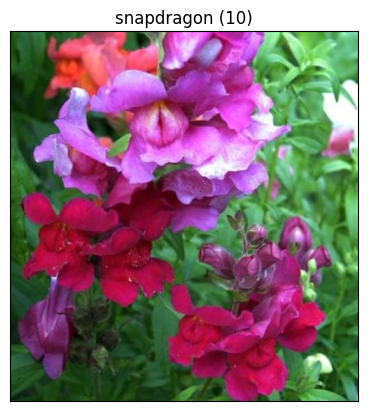

In [7]:
index = 100 #first image
x, y = dataset_train[index] #x: image, y: the label, classes[y]: the actual name of the flower (type str) 

def show(x,y):
    # show image
    plt.imshow(x)
    
    # add title/label and remove tick marks 
    ax = plt.gca()
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.title(f"{classes[y]} ({y})")

show(x,y)

#### 2.2) Show shape and color desomposition
Print the shape and type of the image. Generate three plots, each showing the image only in one color channel in gray scale (`cmap='gray'`)! 

datatype: <class 'numpy.ndarray'>
shape: (531, 500, 3)


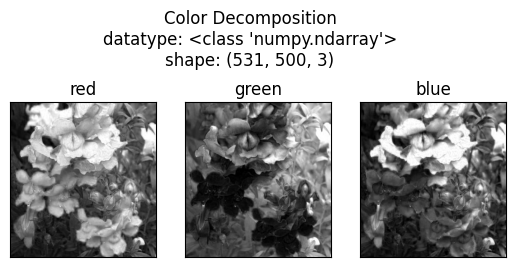

In [8]:
def show_decomposition(x):    
    str_datatype = f"datatype: {type(x)}"
    str_shape = f"shape: {x.shape}"
    print(str_datatype)
    print(str_shape)
    
    colors = ["red", "green", "blue",]
    fig, axs = plt.subplots(ncols=len(colors), squeeze=False)
    fig.suptitle("Color Decomposition\n"  + str_datatype + "\n" + str_shape, y=0.85)
    for i, color in enumerate(colors):
        axs[0,i].imshow(x[:,:,i], cmap='gray')
        axs[0,i].set_title(color)
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show_decomposition(x)

<br>

#### 2.3) Visualize First 8 Classes 
Show an image in the first 8 classes from the dataset to understand what the data looks like.

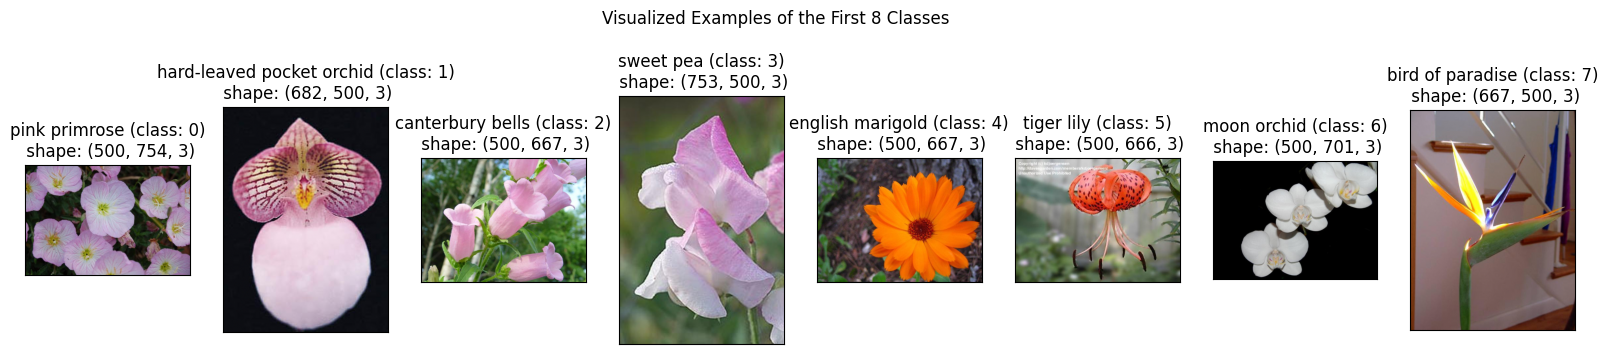

In [9]:
indices = [0, 10, 20, 30, 40, 50, 60, 70]

fig, axs = plt.subplots(ncols=len(indices), squeeze=False, figsize=(20,20))
fig.suptitle("Visualized Examples of the First 8 Classes", y=0.60)
for i, index in enumerate(indices):
        x, y = dataset_train[index]
        axs[0,i].imshow(x)
        axs[0,i].set_title(f"{classes[y]} (class: {y})\n shape: {x.shape}")
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 3) Image Segmentation

#### 3.1) Image Segmentation with K-means clustering
Segment the first image in the training set using K-means clustering. Reshape the image into a 2D array where each row represents a pixel and each column represents a color channel (RGB), and then apply K-means clustering to cluster the pixels. Visualize the segmented image and discuss what you observe.

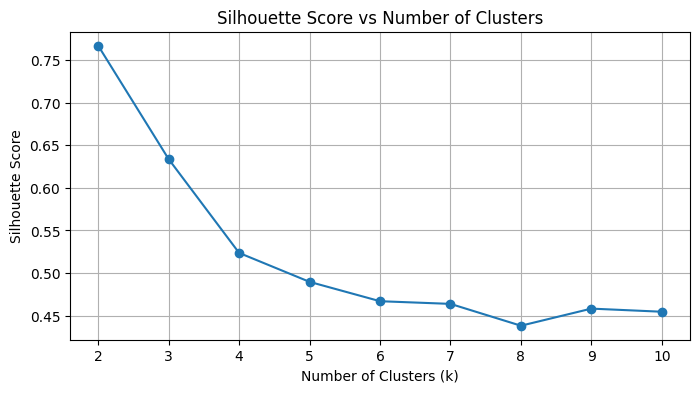

Optimal number of clusters: 2
Train shape: 1020


In [10]:
#%%time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# reshape image
index = 0
x, y = dataset_train[index]
x_np = np.array(x)
x_reshaped = x_np.reshape(-1, 3)

# subsample pixels (otherwise this will take forever)
sample_ratio = 0.005 # ..."Ain't Nobody Got Time for That"
n_samples = int(x_np.size * sample_ratio) 
indices = np.random.choice(x_reshaped.shape[0], n_samples, replace=False)
x_sampled = x_reshaped[indices]

# PCA to reduce further
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x_sampled)

# range of cluster counts to try
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_reduced)
    score = silhouette_score(x_reduced, labels)
    silhouette_scores.append(score)

# plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# best k
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {best_k}")
print(f"Train shape: {len(dataset_train)}")

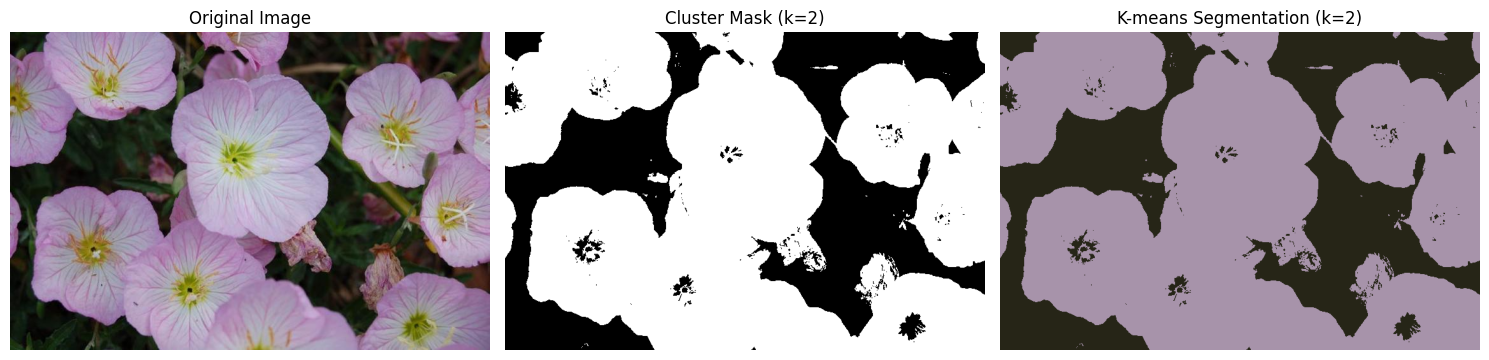

In [11]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load image and reshape
index = 0
x, y = dataset_train[index]  # x: image, y: label
x_np = np.array(x)
x_reshaped = x.reshape(-1, 3)  # (H*W, 3)

# number of clusters
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42)
#kmeans.fit(x_reshaped) 
labels = kmeans.fit_predict(x_reshaped)

# create cluster mask (label image)
# each pixel is assigned a cluster label
label_img = labels.reshape(x_np.shape[:2])  # (H, W)

# replace each pixel with its cluster center
# this will be the cluster's center color
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(x_np.shape)

# plot original, segmented image and cluster mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

# apply a colormap to cluster mask
ax[1].imshow(label_img, cmap="gray")  # or 'nipy_spectral', 'viridis'
ax[1].set_title(f"Cluster Mask (k={k})")
ax[1].axis("off")

# show cluster's center color
ax[2].imshow(segmented_img)
ax[2].set_title(f"K-means Segmentation (k={k})")
ax[2].axis("off")

plt.tight_layout()
plt.show()

*Visualize the segmented image and discuss what you observe.*

We began by estimating the optimal number of clusters for K-means image segmentation using silhouette scores across a range of candidate values.
To accelerate this process, we subsampled the pixel set and applied PCA to reduce the dimensionality from RGB to two principal components, allowing faster and more interpretable clustering.

The silhouette analysis revealed that the optimal number of clusters was two, which aligns with the visual structure of the image.
Each sample typically contains a flower and a background, thus forming two dominant regions.

Using K-means segmentation, we assigned each pixel a cluster label, producing a discrete segmentation map shown in the "Cluster Mask" subplot.
This mask highlights spatial regions grouped by color similarity, effectively separating foreground from background.

Finally, we replaced each pixel with its cluster’s centroid color, yielding a smoothed version of the image where each region is represented by its average color. This segmented image reveals the dominant color modes of the flower and background.

#### 3.2) Visualize the Center Cluster Color
Visualize the center of each cluster as a color using `plt.imshow(colors.reshape(.., .., ..))`. What does this tell you about the image?

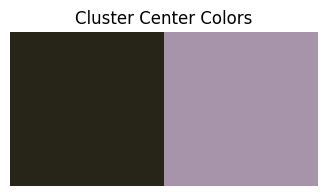

In [12]:
# let's visualize our cluster centers as color swatches
colors = kmeans.cluster_centers_

# reshape as a horizontal strip: (1, k, 3)
color_strip = colors.reshape(1, k, 3)

# show color strip
plt.figure(figsize=(8, 2))
plt.imshow(color_strip)
plt.title("Cluster Center Colors")
plt.axis("off")
plt.show()

*What does this tell you about the image?*

As we meantioned above we each pixel was replaced with its cluster’s centroid color.
This revealed the dominant color modes of the foreground (flower) and background.

#### 3.3) Reconstruct the image using the cluster centers
Reconstruct the image using the cluster centers and the labels assigned to each pixel. Does the reconstructed image capture the main features of the original image? Discuss your observations.

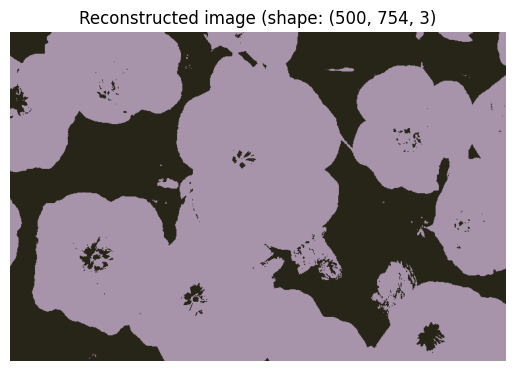

In [13]:
plt.imshow(colors[label_img].reshape(x_np.shape))
plt.axis('off')
plt.title(f'Reconstructed image (shape: {x_np.shape}')
plt.show()

**Discuss your observations.**

As discussed above, we've replaced each pixel with its cluster’s centroid color, thus yielding an image where each region is represented by its cluster’s average color.
This segmented image reveals the dominant color modes of the flower and background.

### 4) Image Clustering

#### 4.1) Hierarchical Clustering

Use hierarchical clustering (`sns.clustermap`) to cluster the first 8 classes of images in the training set. Compute the mean color of the first image in the class and use the mean colors as features. Next, based on the mean colors, generate a distance square matrix (you can use `pdist(your_means, metric='euclidean')`) for clustering. Visualize the resulting dendrogram and discuss what you observe.

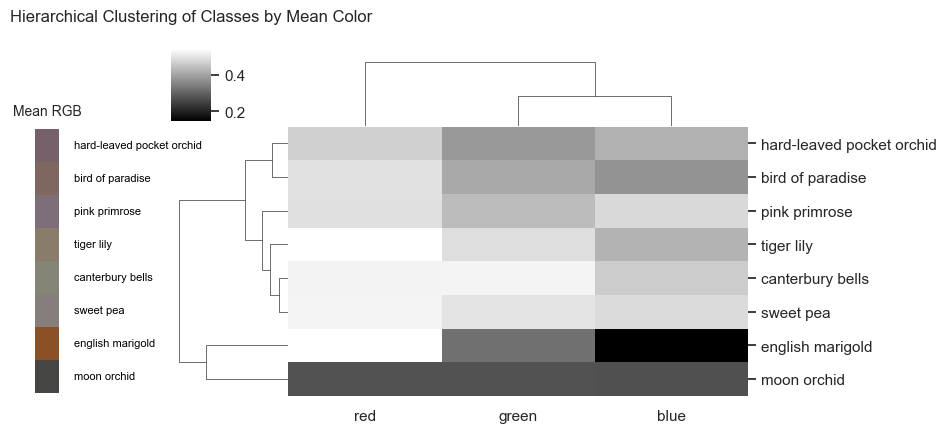

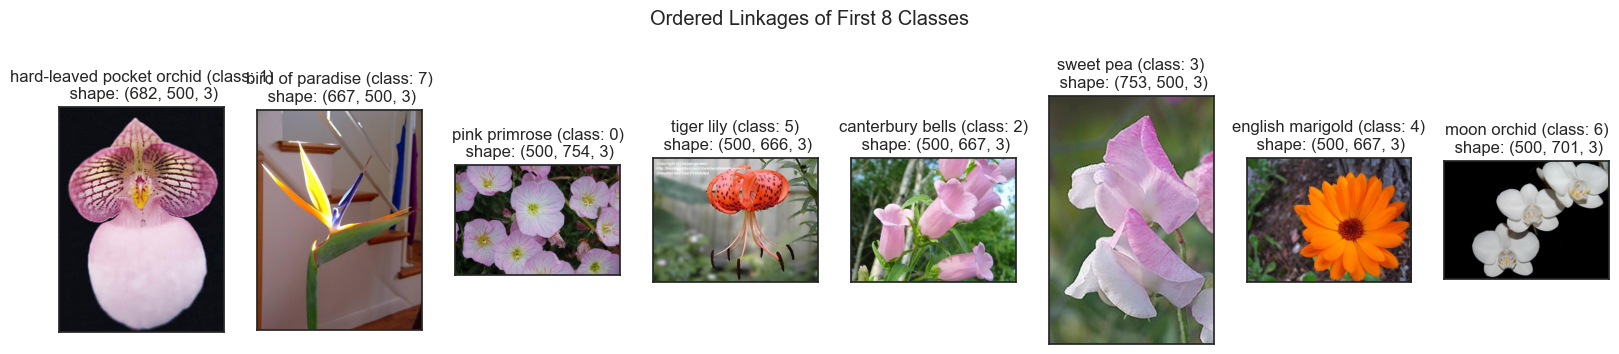

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

indices = [0, 10, 20, 30, 40, 50, 60, 70]
ticks = classes[labels_train[indices]]
xticks = ["red", "green", "blue"]

# get mean colors for each image
mean_colors = []
for index in indices:
    x, y = dataset_train[index]
    x_np = np.array(x)
    mean_color = x_np.reshape(-1, 3).mean(axis=0)  # RGB mean
    mean_colors.append(mean_color)
mean_colors = np.array(mean_colors)  # shape: (8, 3)

# compute pairwise distances
dist_vector = pdist(mean_colors, metric='euclidean')
dist_matrix = squareform(dist_vector)

# visualize using clustermap directly on feature matrix
sns.set(style="white")
g = sns.clustermap(mean_colors,
                   metric='euclidean',
                   #method='average',
                   #method='ward',
                   method='complete',
                   row_cluster=True,
                   col_cluster=True,
                   cmap="gray",
                   xticklabels=xticks,
                   yticklabels=ticks,
                   figsize=(8, 4))

# create color swatches to the left of the row dendrogram
for (color, tick, ytick) in zip(mean_colors, ticks, g.ax_row_dendrogram.get_yticklabels()):
    ytick.set_backgroundcolor(color)
plt.title("Hierarchical Clustering of Classes by Mean Color", pad=20)

# get row order from clustering
row_order = g.dendrogram_row.reordered_ind
ordered_colors = mean_colors[row_order]
ordered_labels = [ticks[i] for i in row_order]

# add RGB swatches as side bar
ax_colorbar = g.fig.add_axes([-0.15, 0.12, 0.03, 0.66])  # [left, bottom, width, height]
ax_colorbar.imshow(ordered_colors.reshape(-1, 1, 3), aspect='auto')
ax_colorbar.axis("off")
ax_colorbar.set_title("Mean RGB", fontsize=10, pad=10)

# annotate each swatch with its class label
for i, label in enumerate(ordered_labels):
    ax_colorbar.text(1.1, i, label, va='center', ha='left', fontsize=8, color='black', transform=ax_colorbar.transData)

'''
# this is where we start to go mad with power...

# reordered data
data = mean_colors[:, g.dendrogram_col.reordered_ind]  # shape: (8, 3)

# per-channel colormaps (clearly we've gone nuts)
channel_maps = [
    plt.cm.Reds,
    plt.cm.Greens,
    plt.cm.Blues
]

# recolor each column
ax = g.ax_heatmap
for col_idx, cmap in enumerate(channel_maps):
    col_data = data[:, col_idx]
    norm = plt.Normalize(vmin=0, vmax=1)
    colors = cmap(norm(col_data)) # will the madness never stop?
    for row_idx, color in enumerate(colors): # why? because it looks cool!
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, facecolor=color, edgecolor='white'))
#... thus ends our "Colour Out of Space"
'''
        
plt.show()

# Recall
ordered_indices = [indices[i] for i in row_order]
fig, axs = plt.subplots(ncols=len(ordered_indices), squeeze=False, figsize=(20,20))
fig.suptitle("Ordered Linkages of First 8 Classes", y=0.60)
for i, index in enumerate(ordered_indices):
        x, y = dataset_train[index]
        axs[0,i].imshow(x)
        axs[0,i].set_title(f"{classes[y]} (class: {y})\n shape: {x.shape}")
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

**Visualize the resulting dendrogram and discuss what you observe.**

Our dendrogram was obtained by hierarchically clustering the mean RGB values of each image using complete linkage and Euclidean distance. Since we are averaging across the entire image, each class reflects a blend of both foreground and background pixels. As a result, the clustering reveals perceptual similarities in overall hue and brightness, rather than precise foreground color.

In the top-level linkages (horizontal axis), we observe that `G` (green) and `B` (blue) are tightly linked, suggesting similar average hues. `R` (red) joins this pair, forming a cluster of visually similar flowers based on their blended mean color.

In the left-side linkages (vertical axis), `english marigold` (4) and `moon orchid` (6) are paired, perhaps indicating shared warm tones. We also see that `hard-leaved pocket orchid` (1) and `bird of paradise` (7) are linked, which may reflect overlapping orange or red hues in their dominant color. However, this is difficult to confirm visually using the mean RGB swatches alone.

The remaining classes form a deeper hierarchy, but again, the visual distinctions are subtle and not easily discernible from the average color representation.

See: **Going Deeper** below, where we cluster based on the foreground cluster center color for improved interpretability.


#### 4.2) Going Deeper (center color of cluster)

Rather than using the average color, let's try using the foreground cluster center color.

In [15]:
def get_foreground_color(index):
    # load image and reshape
    x, y = dataset_train[index]
    x_np = np.array(x)
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # two clusters: background and foreground
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_reshaped)

    # cluster centers (RGB)
    colors = kmeans.cluster_centers_  # shape: (2, 3)

    # compute brightness as mean RGB intensity
    brightness = colors.mean(axis=1)  # shape: (2,)
    brightest_index = np.argmax(brightness)
    brightest_color = colors[brightest_index]  # shape: (3,)

    return brightest_color # the bright one is the foreground

In [16]:
indices = [0, 10, 20, 30, 40, 50, 60, 70]
ticks = classes[labels_train[indices]]
xticks = ["red", "green", "blue"] # is this the correct order?

foreground_colors = []
for index in indices:
    foreground = get_foreground_color(index)
    foreground_colors.append(foreground)

foreground_colors = np.array(foreground_colors)
foreground_colors.shape

(8, 3)

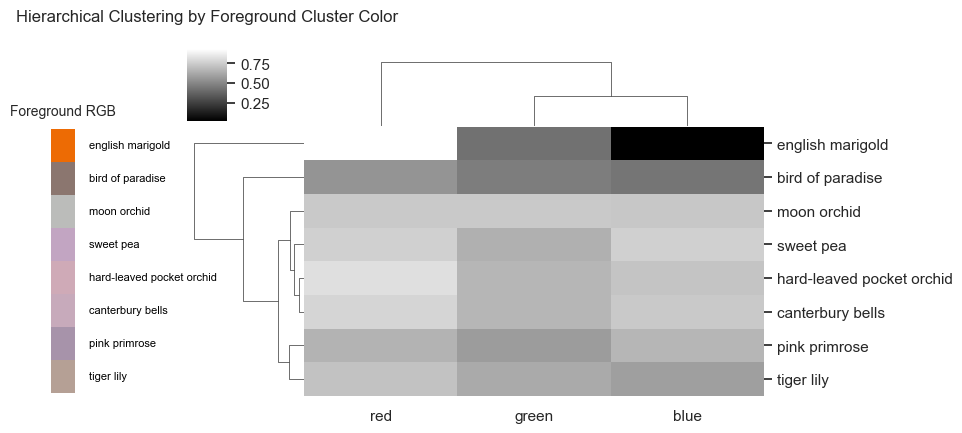

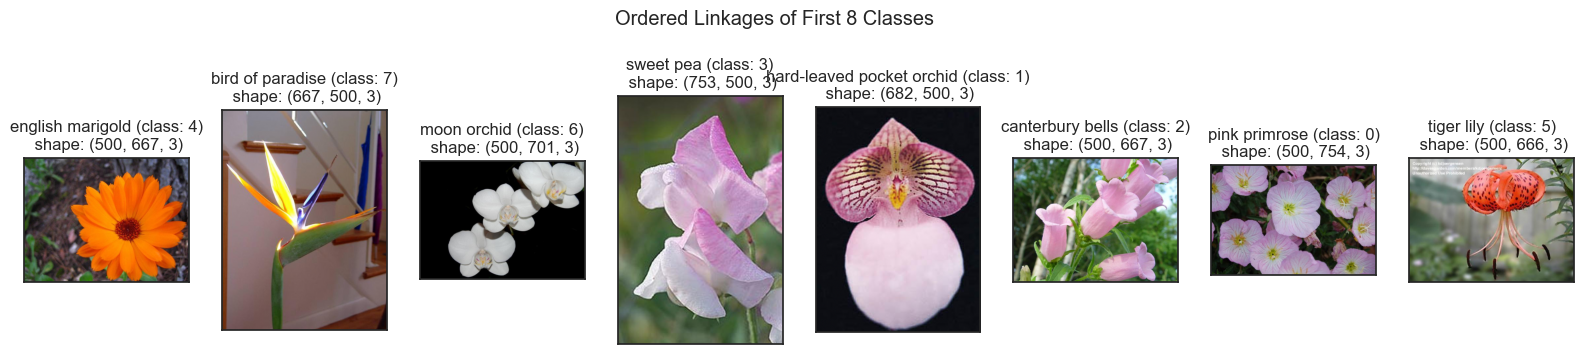

In [17]:
sns.set(style="white")
g = sns.clustermap(foreground_colors,
                   metric='euclidean',
                   #method='average',
                   method='complete',
                   row_cluster=True,
                   col_cluster=True,
                   cmap="gray", #cmap="viridis",
                   xticklabels=xticks,
                   yticklabels=ticks,
                   figsize=(8, 4))
plt.title("Hierarchical Clustering by Foreground Cluster Color", pad=20)

# get row order from clustering
row_order = g.dendrogram_row.reordered_ind
ordered_colors = foreground_colors[row_order]
ordered_labels = [ticks[i] for i in row_order]

# add RGB swatches as side bar
ax_colorbar = g.fig.add_axes([-0.15, 0.12, 0.03, 0.66])  # [left, bottom, width, height]
ax_colorbar.imshow(ordered_colors.reshape(-1, 1, 3), aspect='auto')
ax_colorbar.axis("off")
ax_colorbar.set_title("Foreground RGB", fontsize=10, pad=10)

# annotate each swatch with its class label
for i, label in enumerate(ordered_labels):
    ax_colorbar.text(1.1, i, label, va='center', ha='left', fontsize=8, color='black', transform=ax_colorbar.transData)
plt.show()

# Recall
ordered_indices = [indices[i] for i in row_order]
fig, axs = plt.subplots(ncols=len(ordered_indices), squeeze=False, figsize=(20,20))
fig.suptitle("Ordered Linkages of First 8 Classes", y=0.60)
for i, index in enumerate(ordered_indices):
        x, y = dataset_train[index]
        axs[0,i].imshow(x)
        axs[0,i].set_title(f"{classes[y]} (class: {y})\n shape: {x.shape}")
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [18]:
#ordered_colors, ordered_labels

**Visualize the resulting dendrogram and discuss what you observe.**

Our dendrogram was obtained by hierarchically clustering the foreground cluster center RGB values of each image using complete linkage and Euclidean distance. Each class is represented by its dominant color region, possibly offering a more targeted view of perceptual similarity than mean RGB.

As with the mean RGB dendrogram, the top-level linkages (Horizontal Axis), we observe that `G` (green) and `B` (blue) are tightly linked, again suggesting similar average hues. `R` (red) joins this pair, forming a cluster of visually similar flowers based on dominant color.
*Using HSV might be more interpretable still...*

In the left-side hierarchy (Vertical Axis), we observe a deeper structure:

- `english marigold` (4) connects downward with `bird of paradise` (7), suggesting a transition from the vivid orange of the marigold to the muted reddish-brown of the bird of paradise.
- This branch then links with `pink primrose` (0) and `tiger lily` (5), forming a broader group that blends warm and pastel tones.
- On the opposite side, a separate hierarchy descends from `moon orchid` (6), followed by `sweet pea` (3), `hard-leaved pocket orchid` (1), and finally `canterbury bells` (2).

This structure suggests that foreground color clustering produces more distinct groupings than mean RGB, potentially separating warm-toned flowers (e.g., marigold and bird of paradise) from cooler or more saturated ones. However, this clustering is based solely on RGB centroid values and does not account for spatial or contextual features, which are lost entirely in this representation.

#### 4.3) Going Yet Deeper (HSV)

We might further explore alternate clustering strategies and perceptual color spaces (e.g., HSV or Lab) to improve interpretability and better capture human visual similarity.

Notes:
rgb_to_hsv returns a 3-element array: $[H, S, V]$ where:

$H \in [0, 1] \implies \text{hue}$ (angle on color wheel)

$S \in [0, 1] \implies \text{saturation}$

$V \in [0, 1] \implies \text{brightness}$

In [19]:
from matplotlib.colors import rgb_to_hsv

def get_foreground_color_hsv(index):
    # load image and reshape
    x, y = dataset_train[index]
    x_np = np.array(x)
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # convert all pixels to hsv
    x_hsv = rgb_to_hsv(x_reshaped)

    # two clusters: background and foreground
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_hsv)

    # cluster centers (hsv)
    centers = kmeans.cluster_centers_  # shape: (2, 3)

    # compute brightness as mean of hsv value channel
    brightness = centers[:, 2]  # value channel
    brightest_index = np.argmax(brightness)
    brightest_hsv = centers[brightest_index]  # shape: (3,)

    return brightest_hsv

In [20]:
indices = [0, 10, 20, 30, 40, 50, 60, 70]
ticks = classes[labels_train[indices]]
xticks = ["H", "S", "V"]

foreground_colors = []
for index in indices:
    foreground = get_foreground_color_hsv(index) # use HSV now
    foreground_colors.append(foreground)

foreground_colors = np.array(foreground_colors)
foreground_colors.shape
#foreground_colors[:,2] = 1.0 # set V to maxbrightness

(8, 3)

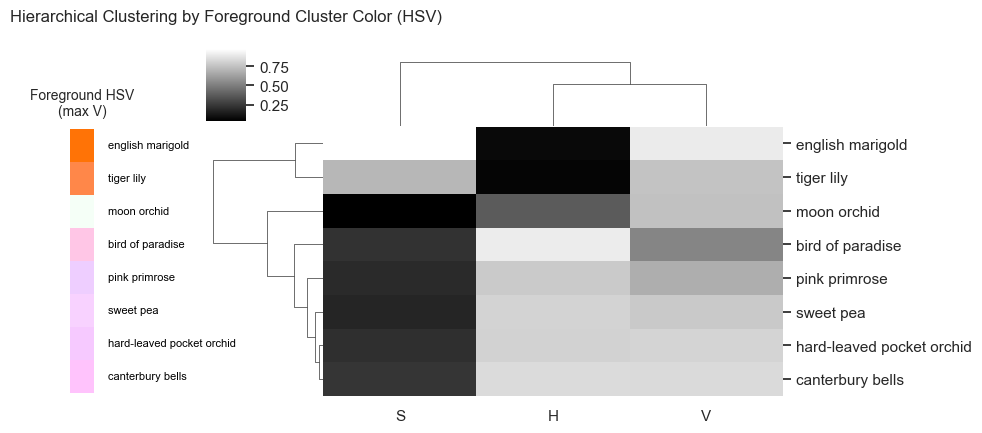

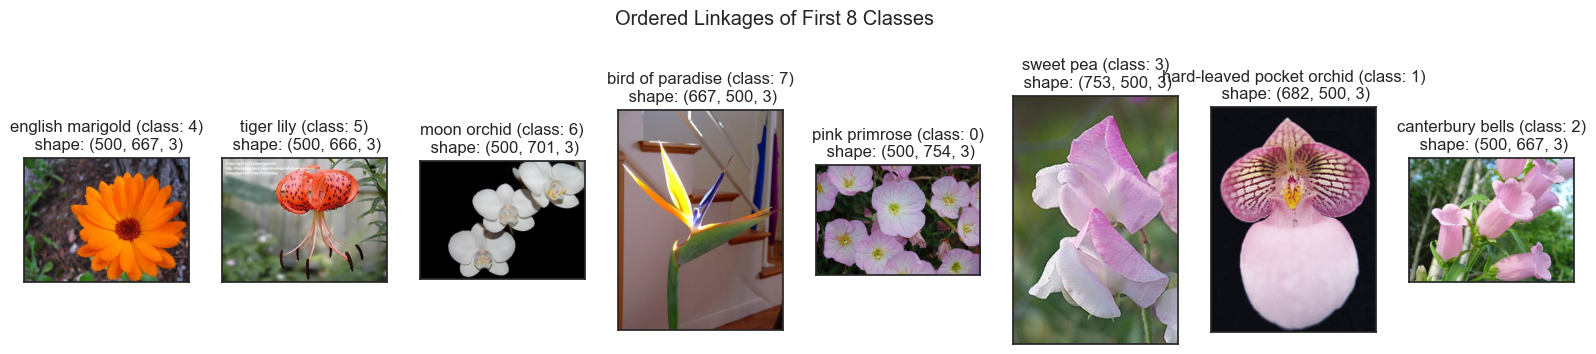

In [21]:
sns.set(style="white")
g = sns.clustermap(foreground_colors,
                   metric='euclidean',
                   #method='average',
                   method='complete',
                   row_cluster=True,
                   col_cluster=True,
                   cmap="gray", #cmap="viridis",
                   xticklabels=xticks,
                   yticklabels=ticks,
                   figsize=(8, 4))
plt.title("Hierarchical Clustering by Foreground Cluster Color (HSV)", pad=20)

# get row order from clustering
row_order = g.dendrogram_row.reordered_ind
ordered_hsv = foreground_colors[row_order]
ordered_labels = [ticks[i] for i in row_order]
ordered_hsv[:,2] = 1.0 # set V to maxbrightness
#ordered_hsv[:,1] = 0.5 # set S
ordered_colors = hsv_to_rgb(ordered_hsv)  # shape: (n, 3)

# add HSV swatches as side bar
ax_colorbar = g.fig.add_axes([-0.15, 0.12, 0.03, 0.66])  # [left, bottom, width, height]
ax_colorbar.imshow(ordered_colors.reshape(-1, 1, 3), aspect='auto')
ax_colorbar.axis("off")
ax_colorbar.set_title("Foreground HSV\n(max V)", fontsize=10, pad=10)

# annotate each swatch with its class label
for i, label in enumerate(ordered_labels):
    ax_colorbar.text(1.1, i, label, va='center', ha='left', fontsize=8, color='black', transform=ax_colorbar.transData)
plt.show()

# Recall
ordered_indices = [indices[i] for i in row_order]
fig, axs = plt.subplots(ncols=len(ordered_indices), squeeze=False, figsize=(20,20))
fig.suptitle("Ordered Linkages of First 8 Classes", y=0.60)
for i, index in enumerate(ordered_indices):
        x, y = dataset_train[index]
        axs[0,i].imshow(x)
        axs[0,i].set_title(f"{classes[y]} (class: {y})\n shape: {x.shape}")
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()    

**Visualize the resulting dendrogram and discuss what you observe.**

Our final dendrogram was obtained by hierarchically clustering the foreground cluster center HSV values of each image using complete linkage and Euclidean distance.
Each class is represented by its dominant color region in HSV.

This approach appears to have improved interpretability, as evidenced by the perceptual ordering of foreground colors.
We observe a smooth transition from the vivid orange of the `english marigold` and `tiger lily`, through the pale whites (with high red-orange content) of the `moon orchid`, and into a continuum of lavender shades spanning from the `bird of paradise` to the `canterbury bells`.

By isolating hue and saturation while controlling for brightness, the HSV-based clustering reveals more coherent visual groupings than RGB methods. It also surfaces perceptual similarities that align more closely with human color intuition, even though spatial and contextual features are entirely absent from this representation.

### 5) Classification

#### 5.1) Decision Tree Classification

Perform decision tree classification using `DecisionTreeClassifier` to predict the flower species based on the features from the K-means clustering. Train the decision tree classifier for class 0 (pink primrose) and class 4 (english marigold) on the training set and evaluate its performance on the validation set by creating a **confusion matrix plot** for both, training and evaluation set. Discuss why or why not the features from K-means clustering might be effective for this classification task.

Loading Training Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.67it/s]


(20, 3) (20,)
Loading Validation Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.85it/s]


(20, 3) (20,)
Fit Model
Accuracy using RGB: 1.00


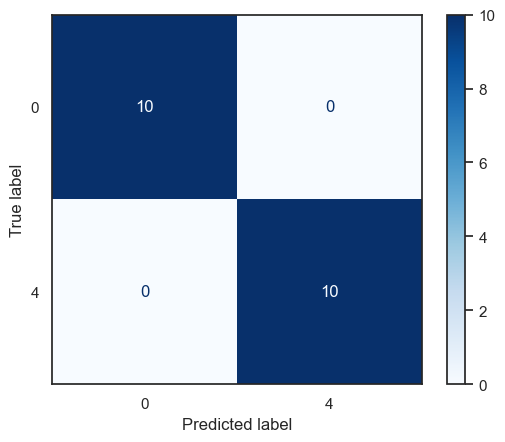

In [22]:
from tqdm import tqdm

indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

def extract_features_rgb(image, n_clusters=2):
    x_np = np.array(image) # in case we want to in pillow later
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # two clusters: background and foreground
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_reshaped)

    # cluster centers (RGB)
    colors = kmeans.cluster_centers_  # shape: (2, 3)

    # compute brightness as mean RGB intensity
    brightness = colors.mean(axis=1)  # shape: (2,)
    brightest_index = np.argmax(brightness)
    brightest_color = colors[brightest_index]  # shape: (3,)

    return brightest_color # the bright one is the foreground

n_clusters = 2
print("Loading Training Set")
x_train = []
y_train = []
for index in tqdm(indices_train):
    x, y = dataset_train[index]  
    x_train.append(extract_features_rgb(x, n_clusters))
    y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
print( x_train.shape, y_train.shape)

print("Loading Validation Set")
x_val = []
y_val = []
for index in tqdm(indices_val):
    x, y = dataset_val[index]  
    x_val.append(extract_features_rgb(x, n_clusters))
    y_val.append(y)
x_val = np.array(x_val)
y_val = np.array(y_val)
print( x_val.shape, y_val.shape)

print("Fit Model")
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

# predict on test data
y_pred = tree.predict(x_val)
proba = tree.predict_proba(x_val)

# plot
accuracy = np.mean(y_pred == y_val)
print(f'Accuracy using RGB: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

** Discuss why or why not the features from K-means clustering might be effective for this classification task.**

With two clusters we can seperate the clusters of foreground and background, as well as, the center color for each.
We can further select the feature (foreground color) based on cluster center with the largest average intensity. 

While RGB intensities somewhat defy human color intuition, and despite the absence of any spatial or contextual features, the RGB center cluster color of the foreground color was sufficent for 100% accurracy and recall.

How cool is that?!

Visualize the decision tree and interpret the results. Discuss which features are most important for classification and how well the model performs. You can visualize the features as colors to help interpret the decision tree.

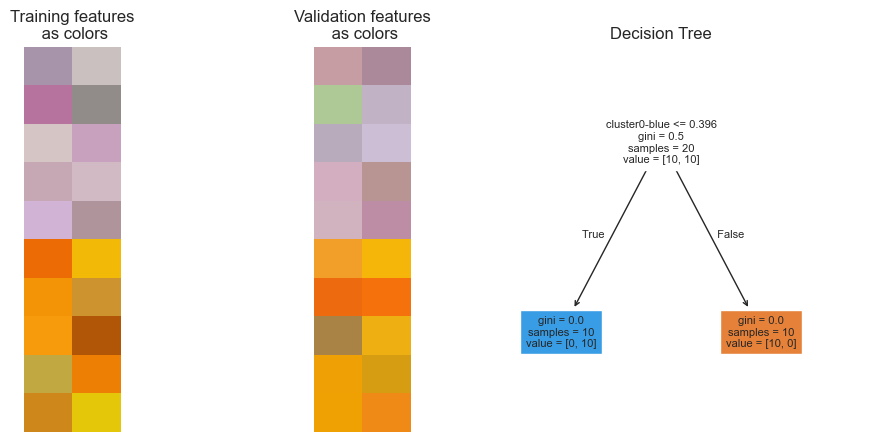

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
fig.subplots_adjust(wspace=2)

# training features as color swatches
axes[0].imshow(x_train.reshape(-1, n_clusters, 3), aspect='auto')
axes[0].axis('off')
axes[0].set_title('Training features\n as colors')

# validation features as color swatches
axes[1].imshow(x_val.reshape(-1, n_clusters, 3), aspect='auto')
axes[1].axis('off')
axes[1].set_title('Validation features\n as colors')

# decision tree plot
ax_tree = fig.add_axes([1, 0.12, 0.80, 0.76])  # [left, bottom, width, height]
feature_names = [f'cluster{i}-{c}' for i in range(n_clusters) for c in ['red', 'green', 'blue']]
plot_tree(tree, filled=True, feature_names=feature_names, fontsize=8, ax=ax_tree)
ax_tree.set_title('Decision Tree')

#plt.tight_layout()
plt.show()

**Discuss which features are most important for classification and how well the model performs.**

The RGB center cluster color of the foreground color was sufficent for 100% accurracy and precision.

Clearly foreground color ($blue \leq 0.396$) is a sufficent metric and key to this model's performance.

#### 5.2) HSV color space

Try a little more feature engineering by, for example, converting the RGB color space to HSV color space (`image = rgb_to_hsv(image)`) before applying K-means clustering, as well as sorting the cluster centers before flattening them into a feature vector. See if these changes improve the classification performance.

Loading Training Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


(20, 6) (20,)
Loading Validation Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]

(20, 6) (20,)
Fit Model
Accuracy using HSV: 0.95


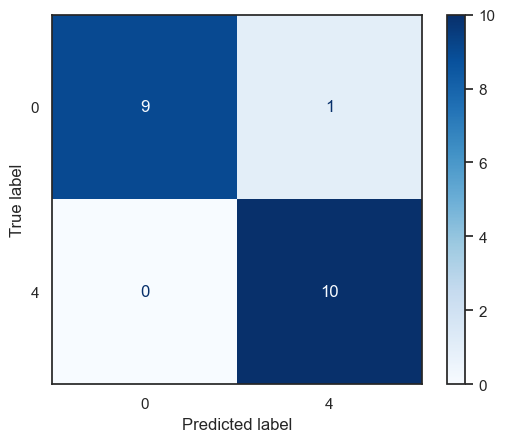

In [24]:
indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

def extract_features_hsv_og(image, n_clusters=2):
    x_np = np.array(image) # in case we want to in pillow later
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # convert all pixels to hsv
    x_hsv = rgb_to_hsv(x_reshaped)

    # clusters: noramally two, background and foreground
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x_hsv)

    # cluster centers (hsv)
    centers = kmeans.cluster_centers_  # shape: (2, 3)

    # compute brightness as mean of hsv value channel
    # we've already effectively flatten the features...
    # as there is only one, the foreground color.
    # this works suprisingly well, so our work here is done...
    brightness = centers[:, 2]  # value channel
    brightest_index = np.argmax(brightness)
    brightest_hsv = centers[brightest_index]  # shape: (3,)

    return brightest_hsv

def extract_features_hsv(image, n_clusters=2):
    x_np = np.array(image)
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # convert all pixels to hsv
    x_hsv = rgb_to_hsv(x_reshaped)

    # cluster in HSV space
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x_hsv)
    centers = kmeans.cluster_centers_  # shape: (n_clusters, 3)

    # sort clusters by brightness (value channel) 
    sorted_indices = np.argsort(centers[:, 2])[::-1]  # descending
    sorted_centers = centers[sorted_indices]

    # flatten to 1D feature vector
    return sorted_centers.flatten()  # shape: (n_clusters * 3,)

print("Loading Training Set")
x_train = []
y_train = []
for index in tqdm(indices_train):
    x, y = dataset_train[index]  
    x_train.append(extract_features_hsv(x, 2))
    y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
print( x_train.shape, y_train.shape)

print("Loading Validation Set")
x_val = []
y_val = []
for index in tqdm(indices_val):
    x, y = dataset_val[index]  
    x_val.append(extract_features_hsv(x, 2))
    y_val.append(y)
x_val = np.array(x_val)
y_val = np.array(y_val)
print( x_val.shape, y_val.shape)

print("Fit Model")
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

# predict on test data
y_pred = tree.predict(x_val)
proba = tree.predict_proba(x_val)

# plot
accuracy = np.mean(y_pred == y_val)
print(f'Accuracy using HSV: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Discuss which features are most important for classification and how well the model performs.**

Using the HSV cluster center of the foreground color alone was sufficient to achieve 100% accuracy and precision. Adding both foreground and background cluster centers, and flattening them into a single feature vector, may help reduce overfitting by introducing more contextual variation.

HSV segmentation and features are more interpretable from a human perceptual standpoint. However, our model performed equally well when using RGB-based segmentation and features.

The RGB-to-HSV transformation is nonlinear, but it remains a deterministic mapping. Despite this, the conversion introduces a slight reduction in color precision. This loss is due to floating point errors that occur during multiplication and addition in the transformation process.

#### 5.3) Final Classification Method

Try your final classification method on class 0 (pink primrose) and class 1 (hard-leaved pocket orchid). How well does it perform? Discuss what kind of features we have not considered that might help improve the classification.

Loading Training Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


(20, 8) (20,)
Loading Validation Set


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]

(20, 8) (20,)
Fit Model
Accuracy using HSV: 0.85


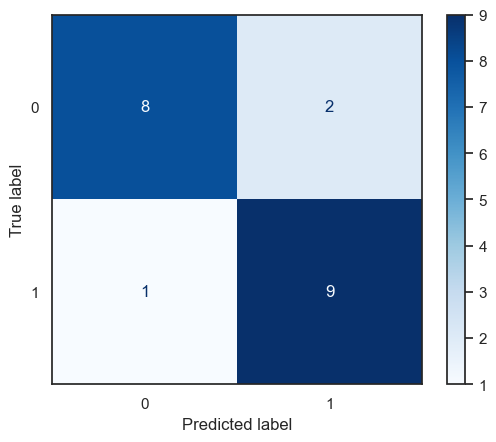

In [25]:
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

#indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
#indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

def extract_features_hsv(image, n_clusters=2):
    x_np = np.array(image)
    x_reshaped = x_np.reshape(-1, 3)  # (H*W, 3)

    # convert RGB to HSV
    x_hsv = rgb_to_hsv(x_reshaped)

    # cluster in HSV space
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x_hsv)
    centers = kmeans.cluster_centers_  # shape: (n_clusters, 3)

    # sort clusters by brightness (value channel)
    sorted_indices = np.argsort(centers[:, 2])[::-1]  # descending
    sorted_centers = centers[sorted_indices]

    # flatten to 1D feature vector
    return sorted_centers.flatten()  # shape: (n_clusters * 3,)

def extract_features_hsv_gmm(image, n_components=2, spatial_weight=0.1):
    x_np = np.array(image)
    h, w, _ = x_np.shape
    x_reshaped = x_np.reshape(-1, 3)
    x_hsv = rgb_to_hsv(x_reshaped)

    # add spatial coordinates
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) / max(h, w)
    x_augmented = np.hstack([x_hsv, spatial_weight * coords])  # shape: (H*W, 5)

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(x_augmented)
    centers = gmm.means_[:, :3]  # HSV only

    # sort by brightness (value channel)
    sorted_indices = np.argsort(centers[:, 2])[::-1]
    sorted_centers = centers[sorted_indices]

    return sorted_centers.flatten()

def extract_features_hsv_gmm_spatial(image, n_components=2, spatial_weight=0.1):
    x_np = np.array(image)
    h, w, _ = x_np.shape
    x_reshaped = x_np.reshape(-1, 3)
    x_hsv = rgb_to_hsv(x_reshaped)

    # normalized spatial coordinates
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) / max(h, w)
    x_augmented = np.hstack([x_hsv, spatial_weight * coords])  # shape: (H*W, 5)

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(x_augmented)
    probs = gmm.predict_proba(x_augmented)
    means = gmm.means_[:, :3]  # HSV centers
    sorted_indices = np.argsort(means[:, 2])[::-1]
    sorted_means = means[sorted_indices]

    # get spatial moments per cluster
    spatial_features = []
    for i in sorted_indices:
        mask = probs[:, i]
        weighted_coords = coords * mask[:, np.newaxis]
        mean_coord = weighted_coords.sum(axis=0) / mask.sum()
        cov_coord = np.cov((coords * mask[:, np.newaxis]).T)
        spatial_features.extend(mean_coord)
        spatial_features.extend(cov_coord[np.triu_indices(2)])  # upper triangle

    # combine HSV + spatial features
    return np.concatenate([sorted_means.flatten(), spatial_features])

def extract_features_rgb_gmm_spatial(image, n_components=2, spatial_weight=0.1):
    x_np = np.array(image)
    h, w, _ = x_np.shape
    x_rgb = x_np.reshape(-1, 3)  # (H*W, 3)

    # add normalized spatial coordinates
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) / max(h, w)
    x_augmented = np.hstack([x_rgb, spatial_weight * coords])  # shape: (H*W, 5)

    # fit GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(x_augmented)
    probs = gmm.predict_proba(x_augmented)
    means = gmm.means_[:, :3]  # RGB centers

    # sort clusters by brightness (mean RGB intensity)
    brightness = means.mean(axis=1)
    sorted_indices = np.argsort(brightness)[::-1]
    sorted_means = means[sorted_indices]

    # compute spatial moments per cluster
    spatial_features = []
    for i in sorted_indices:
        mask = probs[:, i]
        weighted_coords = coords * mask[:, np.newaxis]
        mean_coord = weighted_coords.sum(axis=0) / mask.sum()
        cov_coord = np.cov((coords * mask[:, np.newaxis]).T)
        spatial_features.extend(mean_coord)
        spatial_features.extend(cov_coord[np.triu_indices(2)])  # upper triangle

    # combine RGB + spatial features
    return np.concatenate([sorted_means.flatten(), spatial_features])

def extract_features_hsv_gmm_foreground(image, n_components=2, spatial_weight=0.1):
    x_np = np.array(image)
    h, w, _ = x_np.shape
    x_rgb = x_np.reshape(-1, 3)
    x_hsv = rgb_to_hsv(x_rgb)

    # normalized spatial coordinates
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) / max(h, w)
    x_augmented = np.hstack([x_hsv, spatial_weight * coords])  # shape: (H*W, 5)

    # fit GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(x_augmented)
    probs = gmm.predict_proba(x_augmented)
    means = gmm.means_[:, :3]  # HSV centers

    # identify foreground cluster by brightness (value channel)
    brightness = means[:, 2]
    foreground_index = np.argmax(brightness)
    foreground_hsv = means[foreground_index]  # shape: (3,)

    # compute spatial moments for foreground cluster
    mask = probs[:, foreground_index]
    weighted_coords = coords * mask[:, np.newaxis]
    mean_coord = weighted_coords.sum(axis=0) / mask.sum()
    cov_coord = np.cov((coords * mask[:, np.newaxis]).T)
    spatial_moments = np.concatenate([mean_coord, cov_coord[np.triu_indices(2)]])

    # combine HSV + spatial features
    return np.concatenate([foreground_hsv, spatial_moments])

# hybrid
def extract_features_kmeans_then_gmm(image, n_clusters=2):
    x_np = np.array(image)
    h, w, _ = x_np.shape
    x_rgb = x_np.reshape(-1, 3)
    x_hsv = rgb_to_hsv(x_rgb)

    # KMeans segmentation in HSV
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x_hsv)
    centers = kmeans.cluster_centers_
    brightness = centers[:, 2]  # value channel
    foreground_index = np.argmax(brightness)
    foreground_mask = (labels == foreground_index)

    # extract spatial coordinates of foreground pixels
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) / max(h, w)
    foreground_coords = coords[foreground_mask]

    # fit GMM to foreground spatial layout
    gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    gmm.fit(foreground_coords)
    mean_coord = gmm.means_[0]
    cov_coord = gmm.covariances_[0]

    # combine color + spatial features
    foreground_rgb = centers[foreground_index]
    spatial_features = np.concatenate([mean_coord, cov_coord[np.triu_indices(2)]])
    return np.concatenate([foreground_rgb, spatial_features])

# select model features and parameters
n_clusters=3
extract_features = extract_features_kmeans_then_gmm
#extract_features = extract_features_hsv
#extract_features = extract_features_rgb_gmm_spatial

print("Loading Training Set")
x_train = []
y_train = []
for index in tqdm(indices_train):
    x, y = dataset_train[index]  
    x_train.append(extract_features(x, n_clusters))
    y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
print( x_train.shape, y_train.shape)

print("Loading Validation Set")
x_val = []
y_val = []
for index in tqdm(indices_val):
    x, y = dataset_val[index]  
    x_val.append(extract_features(x, n_clusters))
    y_val.append(y)
x_val = np.array(x_val)
y_val = np.array(y_val)
print( x_val.shape, y_val.shape)

print("Fit Model")
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

# predict on test data
y_pred = tree.predict(x_val)
proba = tree.predict_proba(x_val)

# plot
accuracy = np.mean(y_pred == y_val)
print(f'Accuracy using HSV: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**How well does it perform? Discuss what kind of features we have not considered that might help improve the classification.**

Our classification pipeline evolved through a series of targeted optimizations.
We began with a flattened HSV feature model, which achieved 75\% accuracy but lacked spatial awareness.
To address this, we introduced Gaussian Mixture Models (GMM) to jointly model color and spatial features.
After experimenting with cluster counts, we found that using three clusters yielded the best performance, reaching 85\% accuracy.

To improve efficiency, we developed a hybrid approach that segments the image using KMeans in HSV space and applies GMM only to the spatial coordinates of the brightest foreground region.
This reduced computational overhead while maintaining the same 85\% accuracy.
By combining perceptually aligned color segmentation with shape-aware spatial modeling, we achieved a more robust and interpretable classification pipeline.

**Going Futher**
 - how close are our missclassified species in hue?
 - does spatial spread or orientation contribute the more to misclassification?
 - visualize the spatial (ellipses from GMM covariances) to interpret shape descriptors.
 - change datasplit and/or use data augmentation.
 - explore how segmentation and augmentation might be combined to isolate foreground structures.

# Appendix

## EDA

In [26]:
len(dataset_train), len(dataset_val), len(dataset_test)

(1020, 1020, 6149)

In [27]:
np.sum((labels_train == 0) | (labels_train == 1))

np.int64(20)

In [28]:
np.sum((labels_test == 0) | (labels_test == 1))

np.int64(60)

## Unsupervised Learning Exercise
Lab 12.5.3 Clustering from ISLP, Hastie et al

In [29]:
#!pip install ISLP

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data

from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import (dendrogram, cut_tree)
from ISLP.cluster import compute_linkage

In [31]:
np.random.seed (0);
X = np.random.standard_normal ((50 ,2));
X[:25 ,0] += 3;

In [32]:
kmeans = KMeans(n_clusters =2, random_state =2, n_init =20).fit(X)

In [33]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

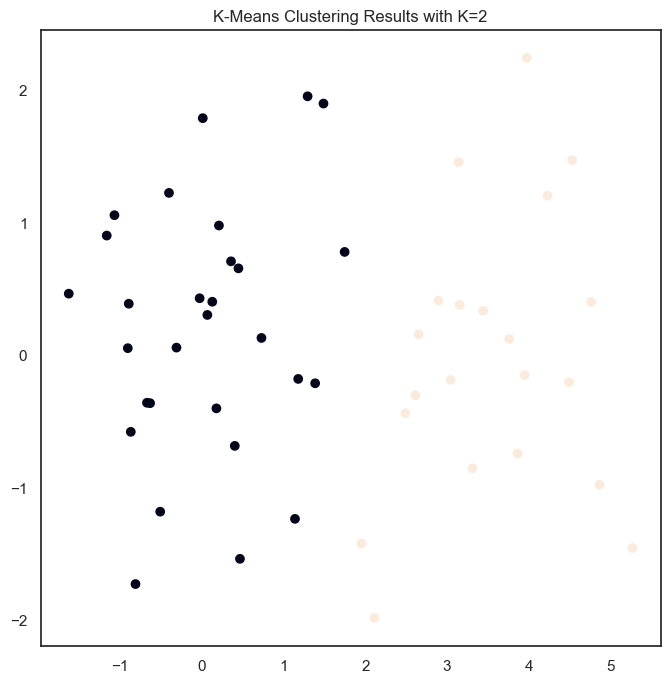

In [34]:
fig , ax = plt.subplots (1, 1, figsize =(8 ,8))
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=2");

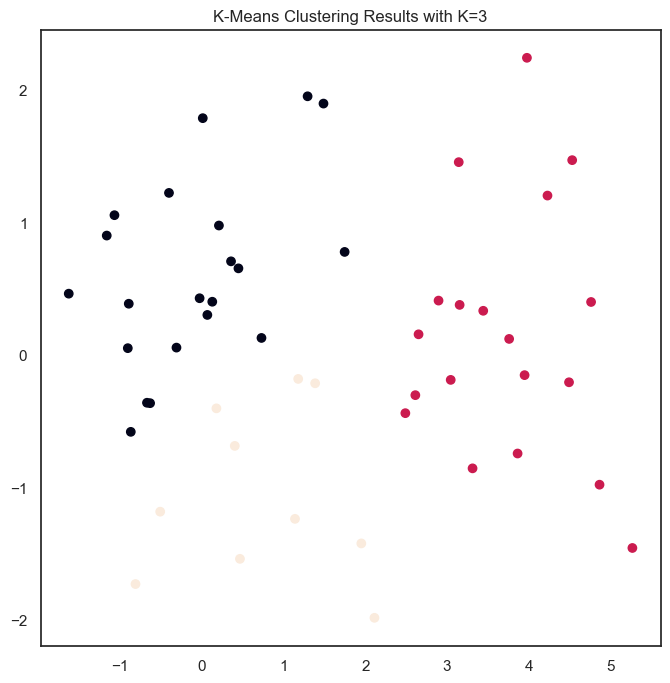

In [35]:
kmeans = KMeans(n_clusters =3, random_state =3, n_init =20).fit(X)
fig , ax = plt.subplots(figsize =(8 ,8))
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=3");

In [36]:
kmeans1 = KMeans(n_clusters =3, random_state =3, n_init =1).fit(X)
kmeans20 = KMeans(n_clusters =3, random_state =3, n_init =20).fit(X);
kmeans1.inertia_ , kmeans20.inertia_

(72.97747016879735, 66.76912177146512)

In [37]:
HClust = AgglomerativeClustering
hc_comp = HClust( distance_threshold =0, n_clusters=None,linkage='complete')
hc_comp.fit(X)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,0
,compute_distances,False


In [38]:
hc_avg = HClust( distance_threshold =0, n_clusters=None, linkage='average');
hc_avg.fit(X)
hc_sing = HClust( distance_threshold =0, n_clusters=None, linkage='single');
hc_sing.fit(X);

In [39]:
D = np.zeros ((X.shape [0], X.shape [0]));
for i in range(X.shape [0]):
    x_ = np.multiply.outer(np.ones(X.shape [0]) , X[i])
    D[i] = np.sqrt(np.sum((X - x_)**2, 1));
    hc_sing_pre = HClust( distance_threshold =0,
    n_clusters=None, metric='precomputed', linkage='single')
hc_sing_pre.fit(D)

,n_clusters,None
,metric,'precomputed'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'single'
,distance_threshold,0
,compute_distances,False


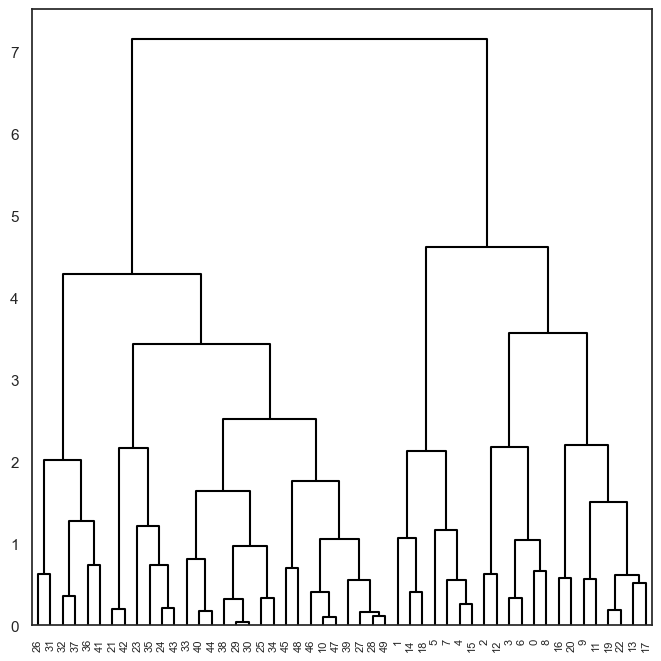

In [40]:
cargs = {'color_threshold':-np.inf, 'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig , ax = plt.subplots (1, 1, figsize =(8, 8))
dendrogram(linkage_comp, ax=ax, ** cargs);

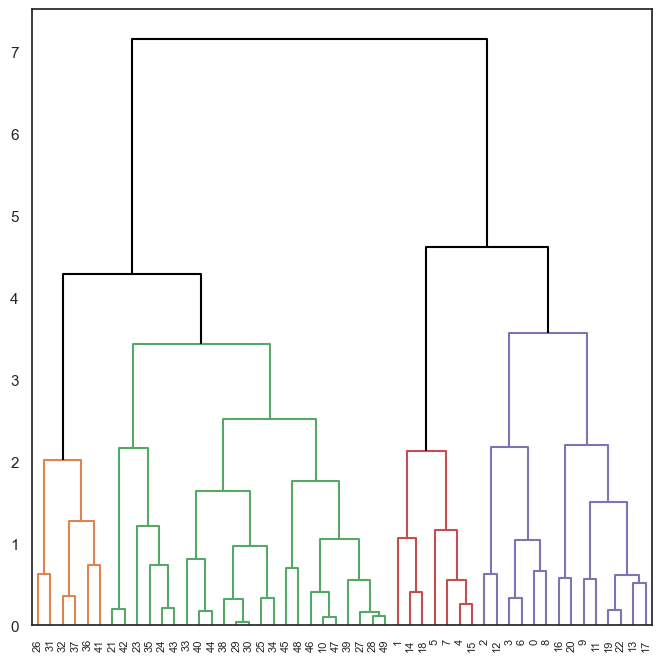

In [41]:
fig , ax = plt.subplots (1, 1, figsize =(8, 8))
dendrogram(linkage_comp, ax=ax, color_threshold = 4, above_threshold_color ='black');

In [42]:
cut_tree(linkage_comp , n_clusters =4).T

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        0, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2,
        2, 2, 2, 2, 2, 2]])

In [43]:
cut_tree(linkage_comp, height=5).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]])

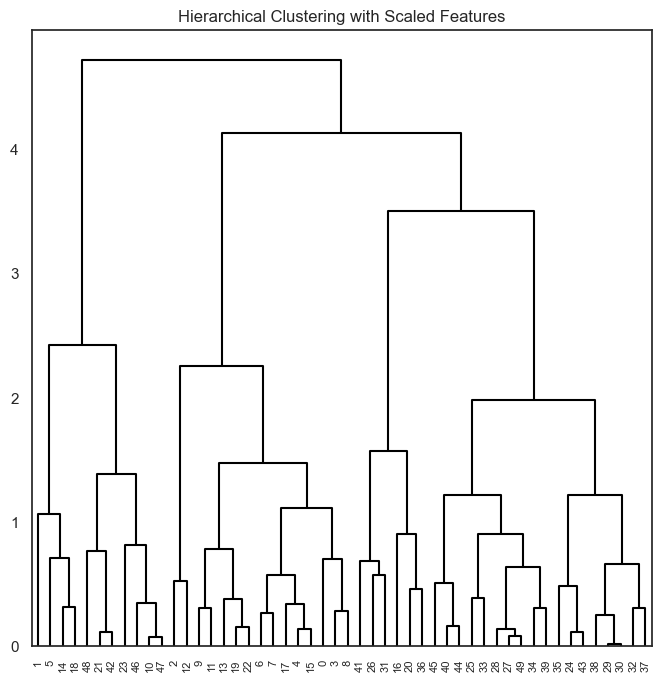

In [44]:
scaler = StandardScaler ()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(distance_threshold=0, n_clusters=None, linkage='complete').fit(X_scale)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig , ax = plt.subplots (1, 1, figsize =(8, 8))
dendrogram(linkage_comp_scale , ax=ax , ** cargs)
ax.set_title("Hierarchical Clustering with Scaled Features");

## API Exploration

References:
 - https://seaborn.pydata.org/generated/seaborn.clustermap.html
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html

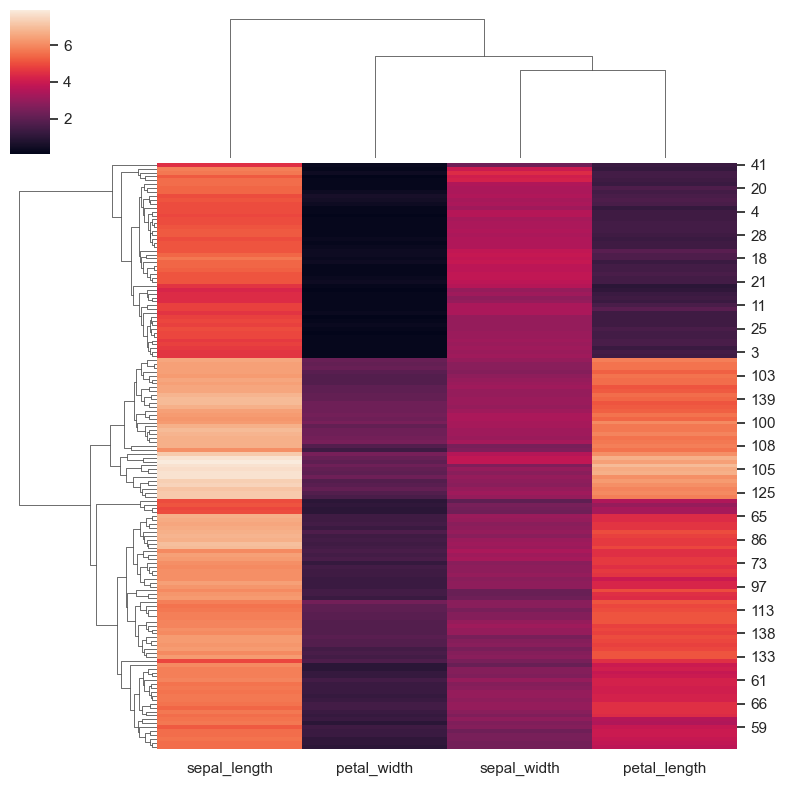

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

iris = sns.load_dataset("iris")
species = iris.pop("species")
sns.clustermap(iris, metric="euclidean", method="average", figsize=(8, 8))
plt.show()

In [46]:
from scipy.spatial.distance import pdist

X = np.array([[0, 0], [1, 0], [0, 1]])
distances = pdist(X, metric='euclidean')
print(distances)  # Condensed distance vector

[1.         1.         1.41421356]


In [47]:
from scipy.spatial.distance import pdist, squareform

X = np.array([[0, 0], [1, 0], [0, 1]])
condensed = pdist(X)
square = squareform(condensed)
print(square)  # Full symmetric distance matrix

[[0.         1.         1.        ]
 [1.         0.         1.41421356]
 [1.         1.41421356 0.        ]]
